In [1]:
# from typing import List, Dict, Tuple, Optional, Callable, Any
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from src.algorithms.adam import AdamOptimizer
from src.algorithms.optimize import (
    optimize_with_one_optimizer,
    optimize_with_multiple_optimizers
)
from src.algorithms.test_functions import (
    mk_quad, mk_gauss,
    rosenbrock, rosenbrock_grad,
    ackley, ackley_grad
)

## Test-Functions

In [2]:
quadratic_good, quadratic_good_grad = mk_quad(1)
quadratic_bad, quadratic_bad_grad = mk_quad(0.02)
gauss, gauss_grad = mk_gauss(1.4)

## Adam Optimizer

In [3]:
torch.manual_seed(0)
initial_guess = torch.rand(2)

objective_function, gradient_function = mk_quad(0.98, ndim=2)

adam_optimizer = AdamOptimizer(0.1)
optimized_theta, min_value, min_gradient = (
    adam_optimizer.minimize(initial_guess, objective_function, gradient_function)
)

print(initial_guess)
print("Optimized Theta:", optimized_theta); print("Minimum Value:", min_value)
print("Gradient at Minimum:", min_gradient)
print("All x_k:", adam_optimizer.all_x_k[:2])
print("All f_k:", adam_optimizer.all_f_k[:2])

tensor([0.4963, 0.7682])
Optimized Theta: tensor([1.5886e-07, 4.3826e-07])
Minimum Value: tensor(1.0485e-13)
Gradient at Minimum: tensor([1.5886e-07, 4.2090e-07])
All x_k: [array([0.4962566, 0.7682218], dtype=float32), array([0.3962573, 0.6682225], dtype=float32)]
All f_k: [array(0.4065324, dtype=float32), array(0.29292947, dtype=float32)]


## Wrapper for Optimizers

In [4]:
###############################################################
########### TESTING `optimize_with_one_optimizer` #############
###############################################################
np.random.seed(42)
x0 = np.array([1.6, 1.1])
x_init = np.random.rand(2)
print(x_init)

solutions, images = optimize_with_one_optimizer(
    optimizer_cls=optim.SGD,
    x_init=x_init, 
    loss_fn=rosenbrock,
    optim_kwargs={"lr": 1e-4, "nesterov": True, "momentum": 0.99, "dampening": 0.},
    max_iter=1000
)
print("======= OPTIM SGD-N FROM (PYTORCH) ========")
print("Final Solution:", solutions[-1], len(solutions))
print("Final Value:", images[-1])


solutions, images = optimize_with_one_optimizer(
    optimizer_cls=AdamOptimizer,
    x_init=x_init,
    loss_fn=rosenbrock,
    loss_grad=rosenbrock_grad,
    optim_kwargs={"lr": 1e-1},
    max_iter=1000
)
print("====== OPTIM ADAM FROM (LOCAL) ============")
print("Final Solution:", solutions[-1], len(solutions))
print("Final Value:", images[-1])

[0.37454012 0.95071431]
======= OPTIM SGD-N FROM (PYTORCH) ========
Final Solution: [1.00872162 1.01755387] 1001
Final Value: 7.767353342179023e-05
====== OPTIM ADAM FROM (LOCAL) ============
Final Solution: [0.99069119 0.98143331] 1001
Final Value: 8.678157698149474e-05


In [5]:
optimizers_config = {
    "Adam (Torch)": (optim.Adam, {"lr": 1e-1}),
    "Adagrad": (optim.Adagrad, {"lr": 1e-1, "lr_decay": 0.1}),
    "RMSprop": (optim.RMSprop, {"lr": 1e-2, "alpha": 0.8}),
    "SGD-Nesterov": (optim.SGD, {"lr": 1e-3, "nesterov": True, "momentum": 0.9, "dampening": 0}),
    "Adam (Local)": (AdamOptimizer, {"lr": 1e-1}),
}
solutions, values = optimize_with_multiple_optimizers(
    x_init=x_init,
    loss_fn=quadratic_good,
    loss_grad=quadratic_good_grad,
    optimizers_config=optimizers_config,
    max_iter=1000,
    tol_grad=1e-6
)
for optimizer, solution in solutions.items():
    print(f"{optimizer} - Final Solution: {solution[-1]}, Final Value: {values[optimizer][-1]}")

Adam (Torch) - Final Solution: [ 6.02684927e-06 -1.41464009e-05], Final Value: 2.719012189264915e-10
Adagrad - Final Solution: [2.13069682e-04 2.52687718e-01], Final Value: 0.031932158452943865
RMSprop - Final Solution: [-3.42153535e-09  3.77161518e-01], Final Value: 0.07459494422859733
SGD-Nesterov - Final Solution: [6.54773456e-06 1.66204489e-05], Final Value: 1.6312550210877113e-10
Adam (Local) - Final Solution: [-1.09025826e-06  3.76243505e-07], Final Value: 6.651111236871735e-13


In [6]:
def plot_convergence(solutions, values, x_star, f_star):
    plt.figure(figsize=(12, 6))

    # Plotting || x - x_star ||
    plt.subplot(1, 2, 1)
    for optim_name in solutions.keys():
        if "local" in optim_name.lower():
            continue
        x_diff = np.linalg.norm(solutions[optim_name] - x_star, axis=1)
        
        # Remove outliers based on z-scores
        plt.plot(np.arange(1, len(x_diff)+1), x_diff, label=f"{optim_name}")

    plt.xlabel('Number of Iterations')
    plt.ylabel('|| x - x_star ||')
    plt.yscale('log')  # Use log scale for better visualization
    plt.legend()
    plt.title('Convergence Path for x')

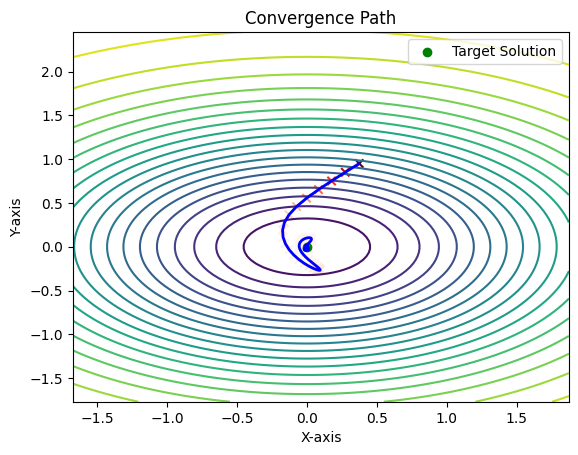

In [7]:
from src.algorithms.optim_utils import plot_convergence_path

solutions_sequence = solutions["Adam (Local)"]
target_solution = torch.tensor([0, 0], dtype=torch.float32)
plot_convergence_path(solutions_sequence, gauss, target_solution)


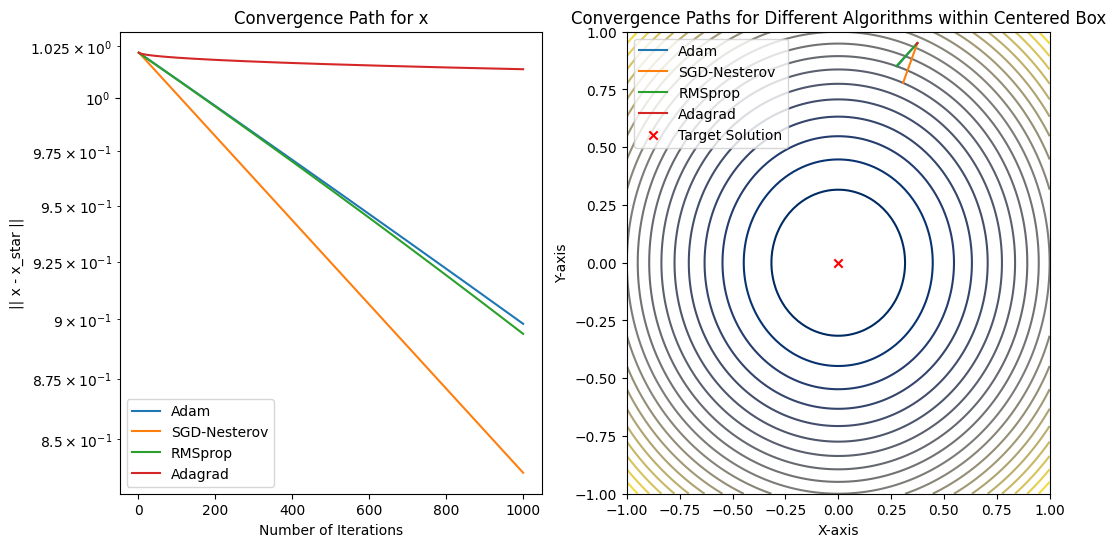

In [32]:
def plot_multiple_convergence_paths(solutions, loss_fn, x_star, box_scale=1.5):
    # ========= Graph 1
    plt.figure(figsize=(12, 6))

    # Plotting || x - x_star ||
    plt.subplot(1, 2, 1)
    for optim_name, path in solutions.items():
        if "local" in optim_name.lower():
            continue
        x_diff = np.linalg.norm(np.array(path) - np.array(x_star), axis=1)
        
        # Remove outliers based on z-scores
        plt.plot(np.arange(1, len(x_diff) + 1), x_diff, label=f"{optim_name}")

    plt.xlabel('Number of Iterations')
    plt.ylabel('|| x - x_star ||')
    plt.yscale('log')  # Use log scale for better visualization
    plt.legend()
    plt.title('Convergence Path for x')

    # ======== Graph 2
    # Convert solutions to torch tensors
    solutions_tensor = {alg: [torch.tensor(sol, dtype=torch.float32) for sol in paths] for alg, paths in solutions.items()}

    # Calculate box boundaries centered around x_star
    all_solutions_np = np.concatenate([np.array(paths) for paths in solutions_tensor.values()])
    x_center, y_center = x_star.numpy()
    x_min, x_max = x_center - box_scale, x_center + box_scale
    y_min, y_max = y_center - box_scale, y_center + box_scale

    # Plot contour levels within the box
    x_range = np.linspace(x_min, x_max, 100)
    y_range = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = loss_fn(torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32))

    plt.subplot(1, 2, 2)
    plt.contour(X, Y, Z, levels=20, cmap='cividis')

    # Plot convergence paths for each algorithm
    for alg, paths in solutions_tensor.items():
        paths_np = np.array([sol.numpy() for sol in paths])
        plt.plot(paths_np[:, 0], paths_np[:, 1], label=alg)

    # Highlight the final solution
    plt.scatter(x_star[0], x_star[1], c='red', marker='x', label='Target Solution')

    # Set plot labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Convergence Paths')

    plt.legend()
    plt.show()


# Example usage:
solutions_dict = solutions
target_solution = torch.tensor([0, 0], dtype=torch.float32)

# Plot convergence paths for different algorithms within a box
plot_multiple_convergence_paths(solutions_dict, quadratic_good, target_solution, box_scale=1)


## Comparison

In [9]:
# Dict[str, Tuple[Callable, Callable, ArrayLike[Shape=2], float]]
# {"Function name": (f, f_gradient, x_star, f_star)}

functions = {
    "Quadratic (poor conditioning, $\kappa=50$)": (quadratic_bad, quadratic_bad_grad, [0,0], 0.0),
    "Quadratic (good conditioning, $\kappa=1$)": (quadratic_good, quadratic_good_grad, [0,0], 0.0),
    "Non-convex Gaussian kernel ($\kappa=1$)": (gauss, gauss_grad, [0,0], 0.0),    
    "Rosenbrock": (rosenbrock, rosenbrock_grad, [1,1], 0.0),
    "Ackley function": (ackley, ackley_grad, [0, 0], 0.0)
}

solutions.keys()


dict_keys(['Adam (Torch)', 'Adagrad', 'RMSprop', 'SGD-Nesterov', 'Adam (Local)'])

In [26]:
from itertools import product
from src.algorithms.optimize import tune_parameters_multiple, tune_parameters, build_optimizers_config

param_grid = {"lr": [0.1, 0.01, 0.001], "betas": [(0.9, 0.999), (0.91, 0.999)]}
optimal = tune_parameters(
    param_grid=param_grid,
    optimizer_cls=optim.Adam,
    x_init=[1.6, 1.1],
    loss_fn=quadratic_good,
    loss_grad=quadratic_good_grad,
    max_iter=1000,
    tol_grad= 1e-6
)
print(optimal)

{'optimal_grid': {'lr': 0.1, 'betas': (0.9, 0.999)}, 'best_n_iter': 214}


In [21]:
# Example usage:
optimizers = {
    "Adam": AdamOptimizer,
    "SGD-Nesterov": optim.SGD,
    "RMSprop": optim.RMSprop,
    "Adagrad": optim.Adagrad,
}
betas1 = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
betas2 = [0.999, 0.9999]
betas = list(product(betas1, betas2))
param_grids = {
    "Adam": {
        "lr": 10.0**np.arange(-4, 2), 
        "beta1": betas1, 
        "beta2": betas2
    }, 
    "SGD-Nesterov": {
        "lr": 10.0**np.arange(-4, 2),
        "nesterov": [True],
        "momentum": betas1,
        "dampening": [0.0]
    },
    "RMSprop": {"lr": 10.0**np.arange(-4, 2), "alpha": betas1},
    "Adagrad": {"lr": 10.0**np.arange(-4, 2)}
}

def optimize_worklow(optimizers, param_grids, x_init, loss_fn, loss_grad, max_iter=1000, tol_grad=1e-6, n_jobs=-1):
    optimal_grids = tune_parameters_multiple(
        optimizers=optimizers,
        param_grids=param_grids,
        x_init=x_init,
        loss_fn=loss_fn,
        loss_grad=loss_grad,
        max_iter=max_iter,
        tol_grad=tol_grad,
        n_jobs=n_jobs
    )
    optimizer_mapping = {
        "adam": AdamOptimizer,
        "sgd-nesterov": optim.SGD,
        "adagrad": optim.Adagrad,
        "rmsprop": optim.RMSprop
    }
    optimizers_config = build_optimizers_config(optimal_grids, optimizer_mapping)

    solutions, values = optimize_with_multiple_optimizers(
        x_init=x_init,
        loss_fn=loss_fn,
        loss_grad=loss_grad,
        optimizers_config=optimizers_config,
        max_iter=max_iter,
        tol_grad=tol_grad
    )
    print(optimal_grids)

    return solutions, values

### Quadratic Function (good conditioning)

In [37]:
x_star = torch.tensor([0, 0])

In [23]:
sol_quad1, val_quad1 = optimize_worklow(
    optimizers, param_grids, x_init, loss_fn=quadratic_good, loss_grad=quadratic_good_grad
)

{'Adam': {'optimal_grid': {'lr': 0.1, 'beta1': 0.5, 'beta2': 0.999}, 'best_n_iter': 44}, 'SGD-Nesterov': {'optimal_grid': {'lr': 1.0, 'nesterov': True, 'momentum': 0.5, 'dampening': 0.0}, 'best_n_iter': 4}, 'RMSprop': {'optimal_grid': {'lr': 0.1, 'alpha': 0.9}, 'best_n_iter': 7}, 'Adagrad': {'optimal_grid': {'lr': 1.0}, 'best_n_iter': 7}}


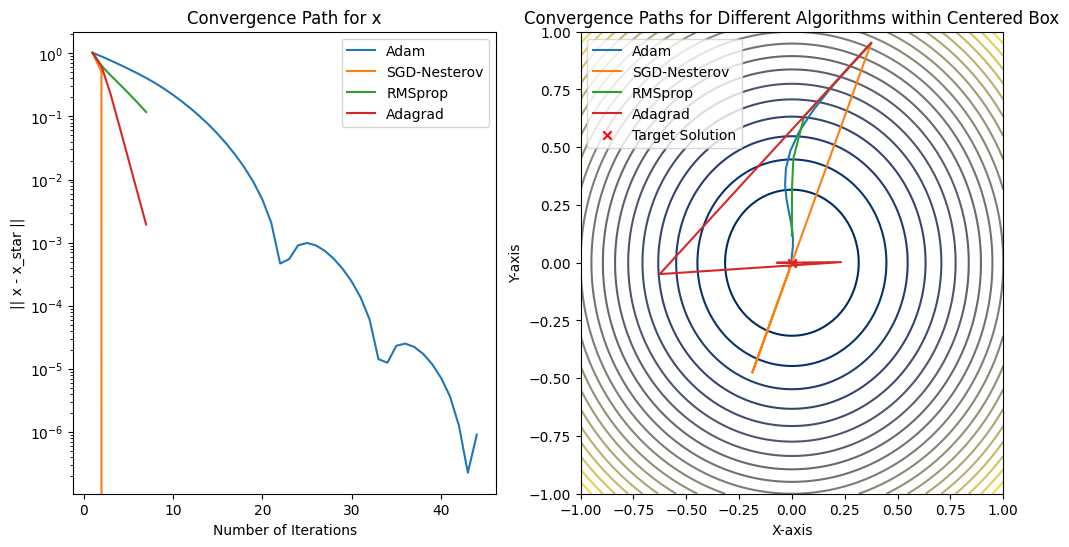

In [38]:
# Plot convergence paths for different algorithms within a box
plot_multiple_convergence_paths(sol_quad1, quadratic_good, x_star, box_scale=1)

### Quadratic Function (bad conditioning)

In [27]:
sol_quad2, val_quad2 = optimize_worklow(
    optimizers, param_grids, x_init, loss_fn=quadratic_bad, loss_grad=quadratic_bad_grad
)

{'Adam': {'optimal_grid': {'lr': 0.1, 'beta1': 0.5, 'beta2': 0.999}, 'best_n_iter': 30}, 'SGD-Nesterov': {'optimal_grid': {'lr': 1.0, 'nesterov': True, 'momentum': 0.5, 'dampening': 0.0}, 'best_n_iter': 4}, 'RMSprop': {'optimal_grid': {'lr': 0.1, 'alpha': 0.9}, 'best_n_iter': 7}, 'Adagrad': {'optimal_grid': {'lr': 1.0}, 'best_n_iter': 4}}


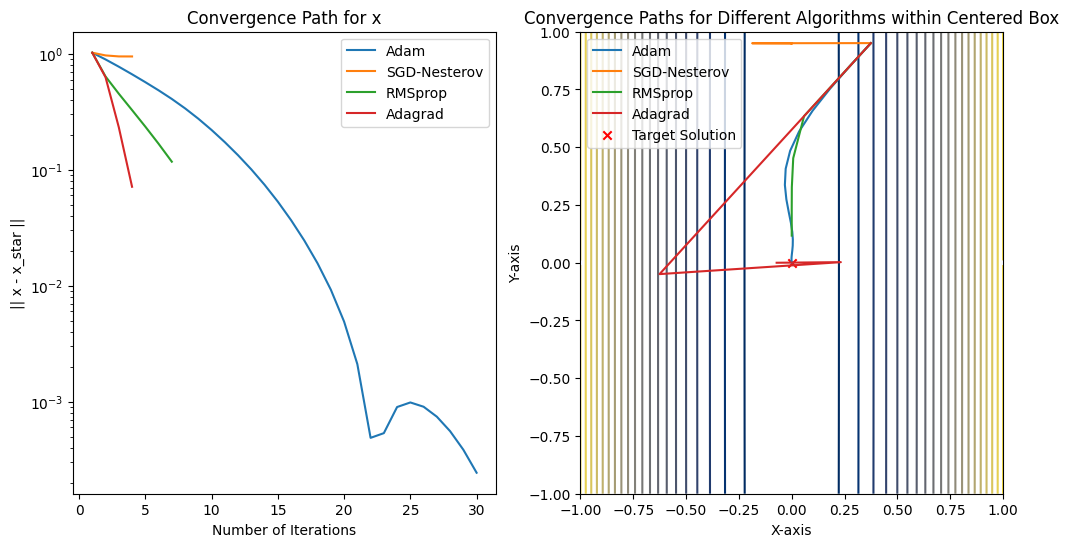

In [39]:
# Plot convergence paths for different algorithms within a box
plot_multiple_convergence_paths(sol_quad2, quadratic_bad, x_star, box_scale=1)

### Non-Convex Gaussian Kernel 

In [28]:
sol_gauss, val_gauss = optimize_worklow(
    optimizers, param_grids, x_init,
    loss_fn=gauss, loss_grad=gauss_grad
)

{'Adam': {'optimal_grid': {'lr': 10.0, 'beta1': 0.5, 'beta2': 0.999}, 'best_n_iter': 3}, 'SGD-Nesterov': {'optimal_grid': {'lr': 10.0, 'nesterov': True, 'momentum': 0.5, 'dampening': 0.0}, 'best_n_iter': 3}, 'RMSprop': {'optimal_grid': {'lr': 10.0, 'alpha': 0.5}, 'best_n_iter': 3}, 'Adagrad': {'optimal_grid': {'lr': 10.0}, 'best_n_iter': 3}}


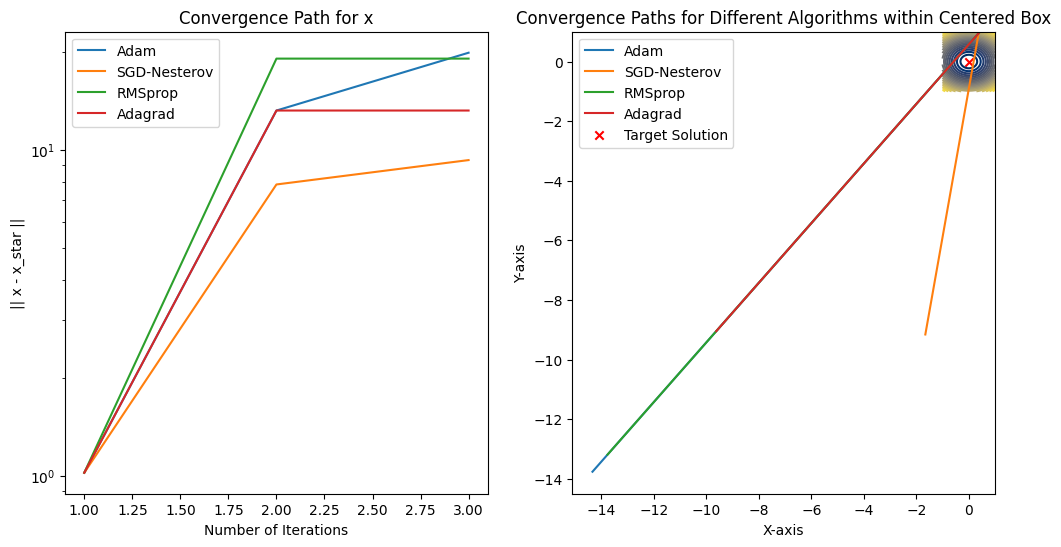

In [40]:
# Plot convergence paths for different algorithms within a box
plot_multiple_convergence_paths(sol_gauss, gauss, x_star, box_scale=1)

### Rosenbrock Function (flat region)

In [29]:
sol_rosen, val_rosen = optimize_worklow(
    optimizers, param_grids, x_init,
    loss_fn=rosenbrock, loss_grad=rosenbrock_grad
)

{'Adam': {'optimal_grid': {'lr': 1.0, 'beta1': 0.95, 'beta2': 0.999}, 'best_n_iter': 925}, 'SGD-Nesterov': {'optimal_grid': {'lr': 0.0001, 'nesterov': True, 'momentum': 0.5, 'dampening': 0.0}, 'best_n_iter': 1001}, 'RMSprop': {'optimal_grid': {'lr': 0.0001, 'alpha': 0.5}, 'best_n_iter': 1001}, 'Adagrad': {'optimal_grid': {'lr': 0.0001}, 'best_n_iter': 1001}}


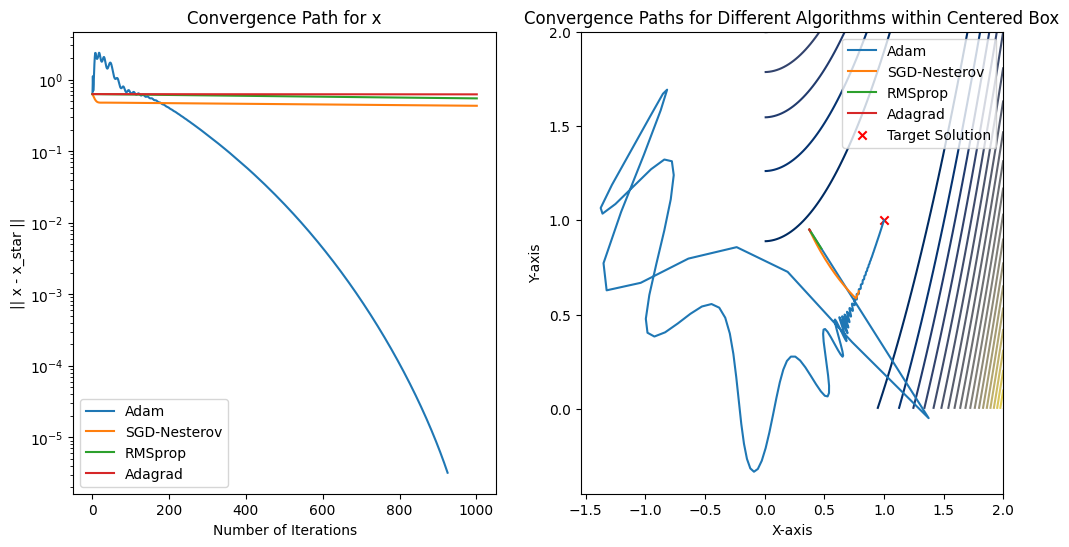

In [41]:
# Plot convergence paths for different algorithms within a box
plot_multiple_convergence_paths(sol_rosen, rosenbrock, x_star=torch.tensor([1,1]), box_scale=1)

### Ackley (local minima)

* [ ] plot convergence path (contour graph, level lines)
* [ ] Final plots: 
  * [ ] 4 columns (1 column per function), 
  * [ ] 10 rows (2 rows per algorithm)
    * [ ] row 1 = difference to minimizer curve
    * [ ] row 2 = convergence path (on contour)

In [30]:
sol_ackley, val_ackley = optimize_worklow(
    optimizers, param_grids, x_init,
    loss_fn=ackley, loss_grad=ackley_grad
)

{'Adam': {'optimal_grid': {'lr': 0.1, 'beta1': 0.5, 'beta2': 0.999}, 'best_n_iter': 46}, 'SGD-Nesterov': {'optimal_grid': {'lr': 0.01, 'nesterov': True, 'momentum': 0.5, 'dampening': 0.0}, 'best_n_iter': 26}, 'RMSprop': {'optimal_grid': {'lr': 0.01, 'alpha': 0.8}, 'best_n_iter': 51}, 'Adagrad': {'optimal_grid': {'lr': 0.1}, 'best_n_iter': 27}}


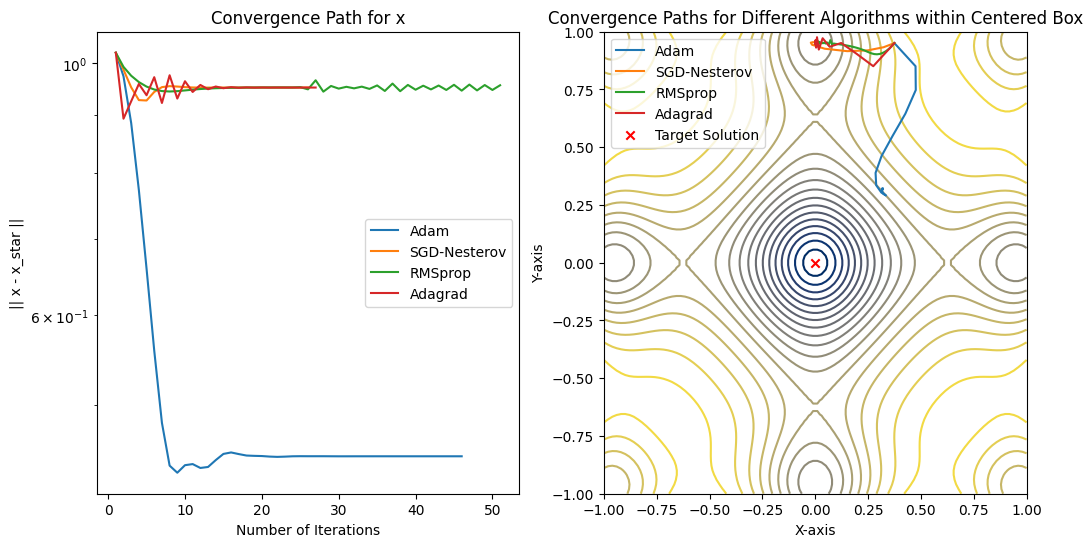

In [42]:
# Plot convergence paths for different algorithms within a box
plot_multiple_convergence_paths(sol_ackley, ackley, x_star, box_scale=1)